In [1]:
%matplotlib inline
import sys
sys.path.append('../')
from src.LRGSG_package.LRGSG import *

In [5]:
# stochastic block model parameters
N1 = N2 = 100
sizes = [N1, N2]
probs = [[0.95, 0.05], [0.05, 0.95]]

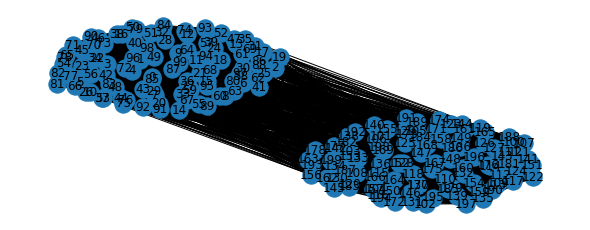

In [6]:
G = nx.stochastic_block_model(sizes, probs, seed=0)
labelList = [i for i in range(G.number_of_nodes())]
plt.figure(figsize=(8,3)) 
nx.draw(G, node_size=300, with_labels = True)

100%|██████████| 1000/1000 [00:00<00:00, 14231.29it/s]


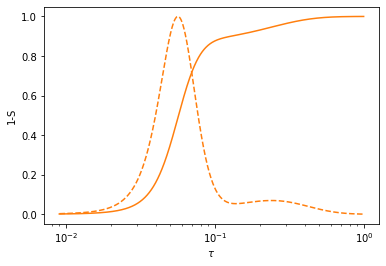

In [7]:
[S1,dS1,VarL1,t1] = entropy(G)

t11 = (t1[1:]+t1[:-1])/2.0
plt.plot(t1, S1, label='ER-05',color='C1')
plt.plot(t11, dS1/np.max(dS1), ls='--',color='C1')

plt.ylabel('1-S')
plt.xlabel(r'$\tau$')

plt.xscale('log')

In [ ]:
# utils
tresh = 0.1
dentroOpts = {'leaf_rotation': 0, 
              'orientation': 'right', 
              'color_threshold': tresh,
              'above_threshold_color': 'k',
              'leaf_font_size': 10,
              'labels': labelList}

In [ ]:
# laplacian, spectrum and densities
L = nx.laplacian_matrix(G).todense()
w = 1. / nx.laplacian_spectrum(G)
tau = w[10]
num = expm((-tau*L))
den = np.trace(num)
rho = num/den
Trho = np.copy(1. / rho)
Trho = np.maximum(Trho, Trho.T)
np.fill_diagonal(Trho, 0)
dists = squareform(Trho)
linkage_matrix1 = linkage(dists, "average")
tmax = linkage_matrix1[::, 2][-1]
linkage_matrix = linkage(dists/tmax, "average")
#
tmin = linkage_matrix[::, 2][0]-0.2*linkage_matrix[::, 2][0]
tmax = linkage_matrix[::, 2][-1]+0.1*linkage_matrix[::, 2][-1]
print(w)

In [ ]:
ax_dict = plt.figure(constrained_layout=True,
                     figsize=(12, 6)).subplot_mosaic("A")

ax_dict['A'].set_xlabel(r'$\mathcal{D}/\mathcal{D}_{max}$')
ax_dict['A'].set_ylabel('Node index')

dendrogram(linkage_matrix, ax=ax_dict['A'], **dentroOpts)
CM = fcluster(linkage_matrix, t=tresh, criterion='distance')
cmap = build_colormap(MiscPalette.TONKA, True)
cmap1 = cmap(np.linspace(0, 1, np.max(CM)))
cmap1[0] = [0., 175/255., 187/255., 1.]
cmap1[1] = [252/255., 78/255., 7/255., 1.]

hierarchy.set_link_color_palette([mplc.rgb2hex(rgb[:3]) for rgb in cmap1])

ax_dict['A'].axvline(x=tresh, c='#ED2939', ls='--')
ax_dict['A'].set_xlim(tmin, tmax)
ax_dict['A'].set_xscale('log')
ax_dict['A'].set_xticks([1e-4, 1e-2, 1e0])
plt.show()

In [ ]:
# stochastic block model with subpartition
G = nx.stochastic_block_model(sizes, probs, seed=1)

for edge in G.edges():
    G.add_edge(edge[0], edge[1], weight=1)
    sign = G.get_edge_data(edge[0], edge[1])

plt.figure(figsize=(8,3)) 
nx.draw(G, node_size=300, with_labels = True)

H = nx.quotient_graph(G, G.graph["partition"], relabel=False)

community1 = list(list(H.nodes())[0])
sub_community1 = community1[:len(community1)//2]
sub_community2 = community1[len(community1)//2:]
for vertex in sub_community1:
    for edge in G.edges(vertex):
        if edge[1] in sub_community2:
            G[edge[0]][edge[1]]['weight'] =-1

In [ ]:
colors = ['r' if G[u][v]['weight'] == -1 else 'k' for u,v in G.edges()]
plt.figure(figsize=(8,3)) 
nx.draw(G, edge_color=colors, node_size=300, with_labels = True)

In [ ]:
# laplacian, spectrum and densities
A = nx.adjacency_matrix(G).toarray()
D = np.diag(np.abs(A).sum(axis=1)) 
L = D-A
w = 1. / eigvals(L)
tau = 2e0
num = expm((-tau*L))
den = np.trace(num)
rho = num/den
Trho = np.copy(1. / rho)
Trho = np.maximum(Trho, Trho.T)
np.fill_diagonal(Trho, 0)
old_d = squareform(Trho)
dists = np.sqrt(1 - old_d/np.max(old_d))
linkage_matrix1 = linkage(dists, "average")
tmax=linkage_matrix1[::, 2][-1]
linkage_matrix = linkage(dists/tmax, "average")
#
tmin = linkage_matrix[::, 2][0]-0.2*linkage_matrix[::, 2][0]
tmax = linkage_matrix[::, 2][-1]+0.1*linkage_matrix[::, 2][-1]
print(w)

In [ ]:
ax_dict = plt.figure(constrained_layout=True,
                     figsize=(12, 6)).subplot_mosaic("A")

dendrogram(linkage_matrix,labels=labelList,ax=ax_dict['A'],leaf_rotation=0,orientation='right',color_threshold=tresh,above_threshold_color='k',leaf_font_size=10)
CM = fcluster(linkage_matrix, t=tresh, criterion='distance')
# cmap = build_colormap(MiscPalette.TONKA, True)
# cmap1 = cmap(np.linspace(0, 1, np.max(CM)))
# cmap1[0]=[0., 175/255., 187/255., 1.]
# cmap1[1]=[252/255., 78/255., 7/255., 1.]
# hierarchy.set_link_color_palette([mplc.rgb2hex(rgb[:3]) for rgb in cmap1])
# ax_dict['A'].axvline(x = tresh, color = '#ED2939', linestyle = '--')
# tmin=linkage_matrix[::, 2][0]-0.2*linkage_matrix[::, 2][0]
# tmax=linkage_matrix[::, 2][-1]+0.1*linkage_matrix[::, 2][-1]
# ax_dict['A'].set_xlim(tmin,tmax)
# ax_dict['A'].set_xlabel(r'$\mathcal{D}/\mathcal{D}_{max}$')
# ax_dict['A'].set_ylabel('Node index')
# ax_dict['A'].set_xscale('log')
# ax_dict['A'].set_xticks([1e0])


plt.show()

In [ ]:
node = 1
for n in [n for n in G.neighbors(node)]:
    print(node, n, G.get_edge_data(node, n))


In [ ]:
[S1,dS1,VarL1,t1]=entropy(G,1000, is_signed=True)

plt.plot(t1,S1,label='ER-05',color='C1')
t11 = (t1[1:]+t1[:-1])/2.0
plt.plot(t11,dS1/np.max(dS1),ls='--',color='C1')

plt.ylabel('1-S')
plt.xlabel(r'$\tau$')

plt.xscale('log')